
0: 640x384 1 id_card, 58.3ms
Speed: 2.8ms preprocess, 58.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


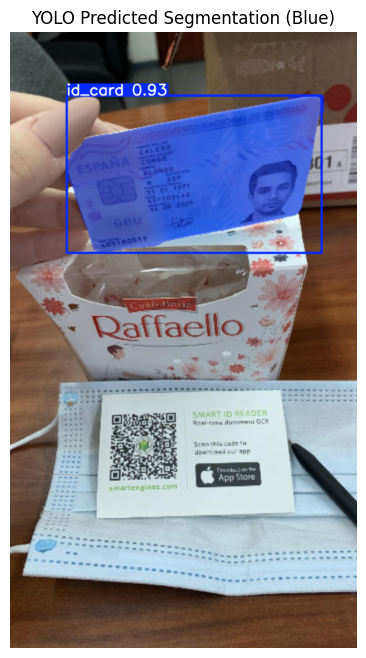


0: 640x384 1 id_card, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


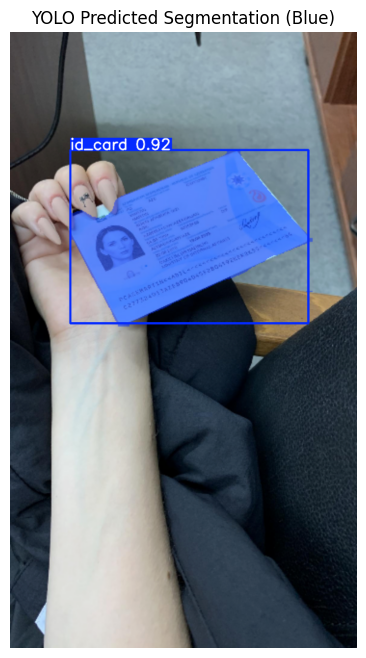

In [7]:
%matplotlib inline

import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Define paths
image_folder = r"C:\Users\zerad\Desktop\Sujan\PassportPAL\data\annotated_images\test\images"
model_path = r"C:\Users\zerad\Desktop\Sujan\PassportPAL\notebooks\PassportPAL-Detector\yolo11m-seg-custom2\weights\best.pt"

# Load YOLO segmentation model
model = YOLO(model_path)

# Get all image files
image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))[:2]

# Process each image
for image_path in image_paths:
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading {image_path}")
        continue

    # Perform segmentation
    results = model(img)

    # Get predicted segmentation mask
    predicted_image = results[0].plot()

    ### **🔹 Process YOLO Predicted Segmentation Masks**
    h, w, _ = img.shape  # Get image dimensions

    for result in results:
        if result.masks is not None:  # Ensure masks exist
            xy_polygons = result.masks.xy  # Polygon format (List of NumPy arrays)
            mask_matrix = result.masks.data.cpu().numpy()  # Mask matrix (num_objects x H x W)

            # Overlay mask matrix on the image
            for mask in mask_matrix:
                mask_resized = cv2.resize(mask, (w, h))  # Resize to match image dimensions
                mask_overlay = (mask_resized > 0.5).astype(np.uint8) * 255  # Binarize the mask
                img = cv2.addWeighted(img, 1, cv2.cvtColor(mask_overlay, cv2.COLOR_GRAY2BGR), 0.4, 0)

            # Draw predicted polygons (Blue)
            for polygon in xy_polygons:
                polygon_scaled = [(int(p[0] * w), int(p[1] * h)) for p in polygon]  # Rescale to image dimensions
                cv2.polylines(predicted_image, [np.array(polygon_scaled, np.int32)], isClosed=True, color=(255, 0, 0), thickness=2)

    # Resize images while maintaining aspect ratio
    def resize_with_aspect_ratio(image, target_width):
        """ Resize image to target width while maintaining aspect ratio """
        h, w = image.shape[:2]
        aspect_ratio = h / w
        new_height = int(target_width * aspect_ratio)
        return cv2.resize(image, (target_width, new_height))

    target_width = 600  # Standard width for all images
    predicted_resized = resize_with_aspect_ratio(predicted_image, target_width)  # YOLO Predictions

    # Display YOLO Predicted Segmentation
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(predicted_resized, cv2.COLOR_BGR2RGB))
    plt.title("YOLO Predicted Segmentation (Blue)")
    plt.axis("off")
    plt.show()


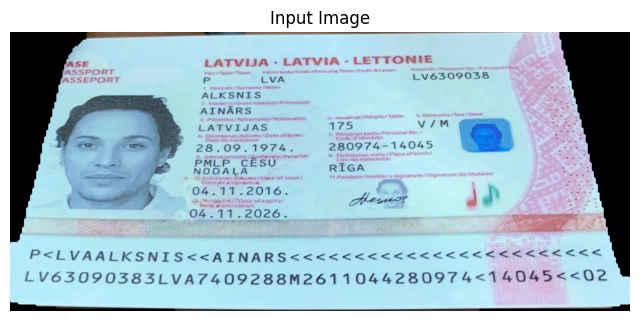

Top 3 Predictions:
lva_passport: 99.98%
est_id: 0.01%
srb_passport: 0.00%


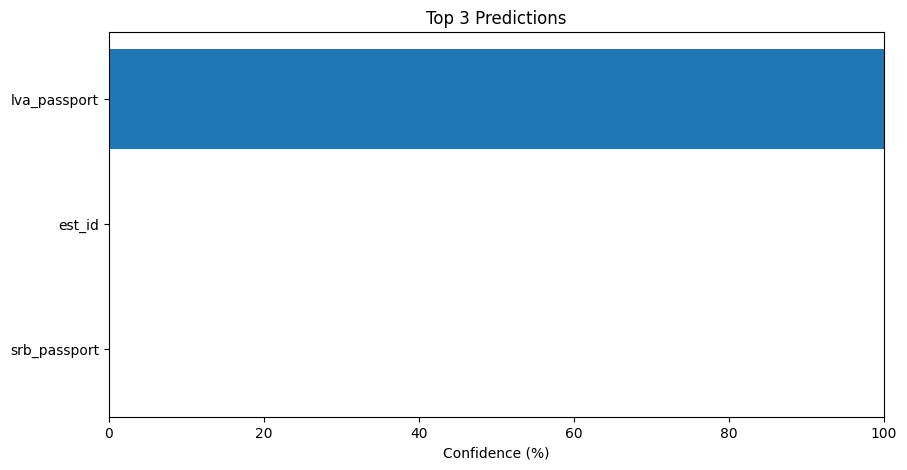

In [5]:
import torch
import cv2
import matplotlib.pyplot as plt
from dataset import get_transforms

# Load TorchScript model
def load_scripted_model(model_path, device):
    """
    Load a TorchScript (.pt) model.
    
    Args:
        model_path (str): Path to the saved model file.
        device (torch.device): Device to load the model on.

    Returns:
        model (torch.jit.ScriptModule): The loaded model.
    """
    model = torch.jit.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    return model

# Load metadata from JSON
import json
def load_metadata(metadata_path):
    with open(metadata_path, 'r') as f:
        return json.load(f)

# Define paths
pt_model_path = r"C:\Users\zerad\Desktop\Sujan\PassportPAL\checkpoints\custom_cnn\custom_cnn_model_scripted.pt"
metadata_path = r"C:\Users\zerad\Desktop\Sujan\PassportPAL\checkpoints\custom_cnn\custom_cnn_model_metadata.json"

# Load model and metadata
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_scripted_model(pt_model_path, device)
metadata = load_metadata(metadata_path)

# Extract metadata
class_names = metadata["class_names"]
img_size = metadata["img_size"]
# Prediction function
def predict_single_image(model, image_path, transform, class_names, device):
    """
    Predict class for a single image and visualize the result.
    
    Args:
        model (torch.jit.ScriptModule): TorchScript model.
        image_path (str): Path to the image file.
        transform (albumentations.Compose): Transformation pipeline.
        class_names (list): List of class names.
        device (torch.device): Device to run inference on.
    """
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display original image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')
    plt.show()
    
    # Apply transformations
    transformed = transform(image=image)
    image_tensor = transformed['image'].unsqueeze(0).to(device)  # Add batch dimension
    
    # Perform inference
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        values, indices = torch.topk(probabilities, 3)  # Get top 3 predictions
    
    # Convert to percentage
    values = values.squeeze().cpu().numpy() * 100
    indices = indices.squeeze().cpu().numpy()
    
    print("Top 3 Predictions:")
    for i in range(len(indices)):
        print(f"{class_names[indices[i]]}: {values[i]:.2f}%")
    
    # Create a horizontal bar chart for visualization
    plt.figure(figsize=(10, 5))
    plt.barh([class_names[idx] for idx in indices[:3]], values[:3])
    plt.xlabel('Confidence (%)')
    plt.title('Top 3 Predictions')
    plt.xlim(0, 100)
    plt.gca().invert_yaxis()  # Highest confidence at the top
    plt.show()

# Get transformation pipeline
transforms_dict = get_transforms(img_size=img_size, use_augmentation=False)
inference_transform = transforms_dict['test']

# Test image path (change accordingly)
test_image_path = r"C:\Users\zerad\Desktop\Sujan\PassportPAL\data\cropped_images\lva_passport\00_seg0.png"

# Run inference
predict_single_image(model, test_image_path, inference_transform, class_names, device)
